In [2]:
import os
from pathlib import Path
import json
import pickle
import math
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set(style="whitegrid")

df = pd.read_pickle("ru_rag_test_dataset_renamed.pkl")
# df = df.rename(columns={
#     "Вопрос": "question",
#     "Правильный ответ": "answer",
#     "Контекст": "context",
#     "Файл": "filename"
# })
# df.to_pickle("ru_rag_test_dataset_renamed.pkl")
df.head()


,question,answer,context,filename
0,Что может вызвать цунами?,Землетрясение,"Землетрясения, извержения вулканов и другие по...",19985.txt
1,Кто написал роман «Хижина дяди Тома»?,Г. Бичер-Стоу,«Хижина дяди Тома» (англ. Uncle Tom's Cabin) —...,273921.txt
2,Кто создал Зимний дворец в Санкт-Петербурге?,Растрелли,Зимний дворец (в 1918—1943 годах — Дворец Иску...,50.txt
3,Какое современное государство занимает террито...,Ирак,"Нине́ви́я или Нин (аккад. 𒌷𒉌𒉡𒀀, Ninwe; ассир. ...",36300.txt
4,Как звали отца Северуса Снейпа?,Тоббиас Снегг (Снейп),Происхождение Снегга в основном стало известно...,172300.txt


In [3]:
import re
#в тексте  много слов с ударениями, очистим от ударений текст и приведем к нижнему регистру
def clean_text(text: str) -> str:
    # Удаляет все ударения из текста.
    return re.sub(r'\u0301', '', text).lower()



In [4]:
df['context'] = df['context'].apply(clean_text)
df['answer']  = df['answer'].apply(clean_text)
df['question']   = df['question'].apply(clean_text)  #


In [5]:
df['context'].iloc[500]

'семилетняя война (1756—1763) — крупный военный конфликт xviii века, один из самых масштабных конфликтов нового времени. семилетняя война шла как в европе, так и за океаном: в северной америке, в странах карибского бассейна, в индии, на филиппинах. в войне приняли участие все европейские великие державы того времени, а также большинство средних и мелких государств европы и даже некоторые индейские племена. уинстоном черчиллем война даже была названа «первой мировой войной». войну считают колониальной, так как в ней столкнулись колониальные интересы великобритании, франции, португалии и испании, а также первой окопной — из-за применения в войне большого количества редутов и других быстровозводимых укреплений — и первой артиллерийской войной: число пушек в ней с 1756 года — 2 на 1000 штыков, с 1759 года — 3—4 пушки на 1000 штыков и 5—6 пушек в 1761 году.'

In [6]:
input_folder = "./files"
output_folder = "./files_cleaned"

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    
    if os.path.isfile(input_path):
        with open(input_path, "r", encoding="utf-8") as f:
            text = f.read()
        
        cleaned_text = clean_text(text)
        
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(cleaned_text)

In [7]:
print('Размер датасета:', len(df))

Размер датасета: 923


In [8]:
for c in ['question','answer','context','filename']:
    if c in df.columns:
        df[c] = df[c].astype(str).fillna("")

for col in ['question','answer','context']:
    if col in df.columns:
        df[f'{col}_chars'] = df[col].str.len()
        df[f'{col}_words'] = df[col].str.split().map(len)

df[['question_chars','question_words','answer_chars','answer_words','context_chars','context_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
question_chars,923.0,45.596966,19.974389,15.0,32.0,41.0,54.0,152.0
question_words,923.0,6.473456,2.682008,3.0,5.0,6.0,7.0,20.0
answer_chars,923.0,16.210184,31.976524,1.0,6.0,10.0,17.0,771.0
answer_words,923.0,2.400867,3.831551,1.0,1.0,1.0,3.0,83.0
context_chars,923.0,423.733478,311.928465,8.0,223.5,351.0,542.0,3962.0
context_words,923.0,59.143012,44.109299,1.0,31.0,49.0,74.0,593.0


In [9]:
print('Строки с пустым контекстом:', (df['context'].str.strip() == '').sum())

Строки с пустым контекстом: 0


In [10]:
if 'filename' in df.columns:
    print('Уникальные filename:', df['filename'].nunique())

Уникальные filename: 839


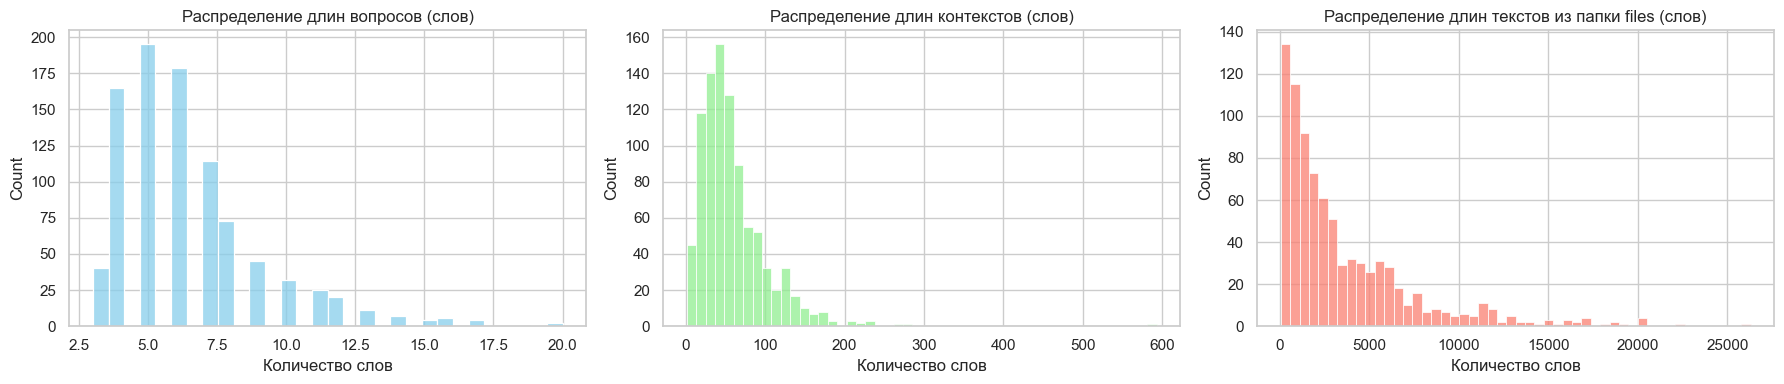

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

df['question_words'] = df['question'].dropna().apply(lambda x: len(x.split()))
df['context_words']  = df['context'].dropna().apply(lambda x: len(x.split()))

folder_path = "files"
file_lengths = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
            word_count = len(text.split())
            file_lengths.append(word_count)

plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
sns.histplot(df['question_words'], bins=30, kde=False, color='skyblue')
plt.title('Распределение длин вопросов (слов)')
plt.xlabel('Количество слов')

plt.subplot(1,3,2)
sns.histplot(df['context_words'], bins=50, kde=False, color='lightgreen')
plt.title('Распределение длин контекстов (слов)')
plt.xlabel('Количество слов')

plt.subplot(1,3,3)
sns.histplot(file_lengths, bins=50, kde=False, color='salmon')
plt.title('Распределение длин текстов из папки files (слов)')
plt.xlabel('Количество слов')

plt.tight_layout()
plt.show()


In [12]:
#  Частотный анализ токенов
all_questions = " ".join(df['question'].tolist()).lower()
q_tokens = all_questions.split()
q_counts = Counter(q_tokens)
print('Топ 30 токенов в вопросах:')
print(q_counts.most_common(30))

folder_path = "files_cleaned"
file_tokens = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().lower()
            file_tokens.extend(text.split())

file_counts = Counter(file_tokens)
print('Топ 30 токенов в текстах:')
print(file_counts.most_common(30))

Топ 30 токенов в вопросах:
[('в', 334), ('какой', 205), ('каком', 166), ('кто', 162), ('году', 82), ('был', 69), ('когда', 69), ('как', 64), ('является', 64), ('какая', 64), ('на', 56), ('где', 53), ('город', 48), ('стране', 46), ('находится', 46), ('и', 46), ('по', 31), ('у', 30), ('написал', 29), ('из', 29), ('городе', 28), ('фильм', 25), ('столицей', 24), ('какое', 20), ('называется', 20), ('была', 19), ('звали', 18), ('с', 16), ('о', 16), ('сколько', 15)]
Топ 30 токенов в текстах:
[('в', 128630), ('и', 87361), ('—', 46872), ('на', 44030), ('с', 30780), ('по', 18913), ('==', 16634), ('не', 15083), ('года', 14757), ('из', 14478), ('===', 14022), ('к', 13234), ('что', 13062), ('году', 11057), ('его', 10280), ('а', 10164), ('от', 10101), ('для', 9798), ('был', 9672), ('как', 9454), ('за', 8353), ('о', 8032), ('он', 7607), ('до', 7271), ('также', 6925), ('после', 6286), ('были', 6018), ('было', 5811), ('была', 5503), ('но', 5419)]


In [13]:
# Классификация типов вопросов 

Q = df['question'].str.lower()

def classify_q(q: str) -> str:
    q = q.lower()
    if q.startswith(('кто', 'чей', 'чья', 'чьё', 'чьи', 'кем', 'кого', 'кому', 'о ком')):
        return 'Вопрос про человека'
    if q.startswith(('где','куда','откуда', "в каком городе", "в каком месте", "в какой стране")):
        return 'Вопрос про место'
    if q.startswith(('когда', 'в каком году', 'в котором году', 'в каком веке', 'в котором веке')):
        return 'Вопрос про время/дату'
    if q.startswith(('сколько', 'на сколько', 'какое число', 'число', 'величина', 'размер', 'длина', 'высота')):
        return 'Вопрос про количество/число'
    if q.startswith(('что','какой','какая','какое','определение','что такое')):
        return 'Вопрос про определение'
    return 'Другое'

df['q_type'] = df['question'].apply(classify_q)
print(df['q_type'].value_counts())

q_type
Другое                         259
Вопрос про определение         203
Вопрос про человека            179
Вопрос про время/дату          146
Вопрос про место               120
Вопрос про количество/число     16
Name: count, dtype: int64


In [14]:
import os
from collections import Counter
import string

folder_path = "files_cleaned"

allowed_chars = set(
    string.ascii_letters + string.digits + string.punctuation + " \n\t" +
    "абвгдеёжзийклмнопрстуфхцчшщъыьэюя" +
    "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
)

def find_weird_chars(text):
    return [c for c in text if c not in allowed_chars]

weird_counter = Counter()

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
            weird_counter.update(find_weird_chars(text))

print("Топ-20 странных символов и их частота:")
for char, freq in weird_counter.most_common(20):
    print(f"'{char}' : {freq}")

Топ-20 странных символов и их частота:
'—' : 54871
'«' : 50952
'»' : 50943
'…' : 1875
'№' : 1715
'„' : 1040
'“' : 1040
'°' : 852
'’' : 683
'²' : 500
'­' : 464
'і' : 436
'−' : 429
'é' : 357
' ' : 333
' ' : 277
'α' : 227
'×' : 209
'³' : 201
'ο' : 169


In [15]:
files_dir = Path('files')
corpus = []
corpus_ids = []

if files_dir.exists() and files_dir.is_dir():
    for p in files_dir.glob('*'):
        text = p.read_text(encoding='utf-8', errors='ignore')
        corpus.append(text)
        corpus_ids.append(p.stem)
    print('Загружено файлов из files:', len(corpus))

print('Документов в корпусе:', len(set(corpus_ids)))

Загружено файлов из files: 838
Документов в корпусе: 838


In [16]:
import re

def simple_tokenize(text):
    tokens = re.findall(r"\w+|\S", text)
    return tokens

def chunk_text(text, chunk_size=200, overlap=50):
    tokens = simple_tokenize(text)
    if len(tokens) <= chunk_size:
        return [text]
    chunks = []
    i = 0
    while i < len(tokens):
        chunk = tokens[i:i+chunk_size]
        chunks.append(' '.join(chunk))
        i += chunk_size - overlap
    return chunks

chunked_corpus = []
chunked_ids = []
for i, txt in enumerate(corpus[:200]):
    chs = chunk_text(txt, chunk_size=200, overlap=50)
    for j, ch in enumerate(chs):
        chunked_corpus.append(ch)
        chunked_ids.append(f'{i}_chunk{j}')

print('Пример chunked_corpus size:', len(chunked_corpus))

Пример chunked_corpus size: 5673


# Проверим что контексты содержат ответы

In [17]:
# !pip install sentence_transformers

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

def contains_answer(row):
    return row['answer'].strip() in row['context']

df['answer_in_context'] = df.apply(contains_answer, axis=1)

pct = df['answer_in_context'].mean()


In [22]:
print(f"Процент случаев, когда ответ содержится дословно в контексте: {pct:.2%}")

Процент случаев, когда ответ содержится дословно в контексте: 50.16%


In [19]:
from itertools import tee
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    tokens = re.findall(r'\w+', text.lower())
    lemmas = [morph.parse(t)[0].normal_form if t.isalpha() else t for t in tokens]
    return lemmas

def ngrams(tokens, n=1):
    if len(tokens) < n:
        return []
    return list(zip(*[tokens[i:] for i in range(n)]))

def ngram_overlap(answer, context, n=1):
    a_tokens = lemmatize(answer)
    c_tokens = lemmatize(context)
    a_ngrams = set(ngrams(a_tokens, n))
    c_ngrams = set(ngrams(c_tokens, n))
    if not a_ngrams:
        return 0.0
    return len(a_ngrams & c_ngrams) / len(a_ngrams)

df['uni_overlap'] = df.apply(lambda r: ngram_overlap(r['answer'], r['context'], 1), axis=1)
df['bi_overlap']  = df.apply(lambda r: ngram_overlap(r['answer'], r['context'], 2), axis=1)
df['tri_overlap'] = df.apply(lambda r: ngram_overlap(r['answer'], r['context'], 3), axis=1)

print("Униграммы:", df['uni_overlap'].mean())
print("Биграммы:", df['bi_overlap'].mean())
print("Триграммы:", df['tri_overlap'].mean())
# низкие значения биграмм и триграмм говорят, что ответ не является прямой цитатой из контекста


Униграммы: 0.8098636663882749
Биграммы: 0.2734735139664717
Триграммы: 0.10647693857762845


In [20]:
low_uni = df.sort_values('uni_overlap', ascending=True).head(10)

print("Примеры с минимальным пересечением униграмм (ответ сильно переформулирован или ошибки)")
for i, row in low_uni.iterrows():
    print(f"Пример {i+1}")
    print(f"Вопрос: {row['query'] if 'query' in df.columns else row.get('question', '')}")
    print(f"Ответ: {row['answer']}")
    print(f"Контекст: {row['context']}")
    print(f"uni_overlap = {row['uni_overlap']:.3f}, bi_overlap = {row['bi_overlap']:.3f}, tri_overlap = {row['tri_overlap']:.3f}")


Примеры с минимальным пересечением униграмм (ответ сильно переформулирован или ошибки)
Пример 363
Вопрос: что прежде носило название сандвичевы острова?
Ответ: гавайи
Контекст: гавайские острова для европейцев открыл 18 января 1778 года знаменитый английский мореплаватель джеймс кук во время своего 3-го путешествия по тихому океану (здесь же он и погиб 14 февраля 1779 года, когда вернулся на зимовку после плавания по северной части тихого океана). кук дал им название сандвичевы острова (это название использовали до конца xix века) в честь первого лорда адмиралтейства джона монтегю, 4-го графа сэндвича.
uni_overlap = 0.000, bi_overlap = 0.000, tri_overlap = 0.000
Пример 898
Вопрос: какое издательство выпускало сатирический журнал крокодил?
Ответ: рабочая газета
Контекст: в 1922—1926 годах активно сотрудничал с «известиями», в 1926—1929 годах — с «комсомольской правдой». печатался в журналах «новый мир», «молодая гвардия», «огонёк», «крокодил», «красная нива» и др.
uni_overlap = 0.000, b